# Interpolation of field variables

Author(s): Jukka Aho

Abstract: Let's interpolate and visualize a scalar field from 4 element model.

In [2]:
using JuliaFEM: Element, Quad4, get_basis, set_field, get_field, get_dbasisdxi

In [3]:
coordinates = [0.0 2.0; 1.0 2.0; 2.0 2.0; 0.0 1.0; 1.0 1.0; 2.0 1.0; 0.0 0.0; 1.0 0.0; 2.0 0.0]'
temperature = [0.0  140.0  190.0  0.0  155.0  310.0  0.0  170.0  430.0]

elements = Element[
    Quad4([4, 5, 2, 1]),
    Quad4([5, 6, 3, 2]),
    Quad4([7, 8, 5, 4]),
    Quad4([8, 9, 6, 5])]

for el in elements
    set_field(el, "coordinates", coordinates[:, el.node_ids])
    set_field(el, "temperature", temperature[:, el.node_ids])
end

Basic interpolation wrt local coordinates $\xi$:

In [4]:
"""
Evaluate field in point xi using basis functions.
"""
function interpolate(el::Element, field::ASCIIString, xi::Array{Float64,1})
    f = get_field(el, field)
    basis = get_basis(el, xi)
    dim, nnodes = size(f)
    result = zeros(dim)
    for i=1:nnodes
        result += basis[i]*f[:,i]
    end
    return result
end

interpolate(elements[4], "temperature", [1.0, -1.0]), interpolate(elements[1], "coordinates", [0.0, 0.0])

([430.0],[0.5,1.5])

Find local coordinate $\xi$ where field equals to some given value:

In [5]:
function get_xi(el::Element, field::ASCIIString, value::Vector)
    fld = get_field(el, field)
    dbasisdxi(xi) = get_dbasisdxi(el, xi)
    rhs(xi) = interpolate(el, field, xi) - value
    lhs(xi) = fld*dbasisdxi(xi)
    xi = zeros(length(value))
    for i=1:5
        A = rhs(xi)
        b = lhs(xi)
        #println("$A, $b")
        dxi = lhs(xi) \ rhs(xi)
        xi -= dxi
        if norm(dxi) < 1.0e-9
            break
        end
    end
    return xi[:]
end

xi0 = get_xi(elements[4], "coordinates", [2.0, 0.0])
println("$xi0")
interpolate(elements[1], "coordinates", xi0)

[1.0,-1.0]


2-element Array{Float64,1}:
 1.0
 1.0

Test if point is inside element:

In [6]:
function point_inside_element(el::Quad4, pnt)
    all(-1 .<= get_xi(el, "coordinates", pnt) .<= 1)
end

point_inside_element (generic function with 1 method)

In [7]:
point_inside_element(elements[1], [0.8, 2.01]), point_inside_element(elements[4], [2.0, 0.0])

(false,true)

Interpolate field variable from set of elements

In [8]:
function interpolate(elements::Array{Element,1}, field::ASCIIString, pnt::Array{Float64,1}, nullval=0.0)
    elements = filter((el) -> point_inside_element(el, pnt), elements)
    if length(elements) == 0
        # outside of region
        return nullval
    end
    xi = get_xi(elements[1], "coordinates", pnt)
    return interpolate(elements[1], field, xi)
end

interpolate (generic function with 3 methods)

In [9]:
interpolate(elements, "temperature", [2.0, 0.0])

1-element Array{Float64,1}:
 430.0

In [10]:
y = linspace(0,2,100)
x = y'
T = zeros(length(x), length(y))
for i=1:length(x)
    for j=1:length(y)
        T[i,j] = interpolate(elements, "temperature", [x[i], y[j]])[1]
    end
end
T = T';

In [11]:
using PyPlot

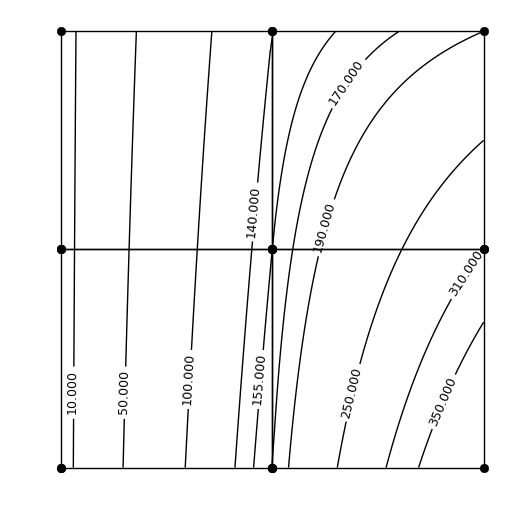

(-0.1,2.1,-0.1,2.1)

In [17]:
figure(figsize=(6, 6))
levels = [10, 50, 100, 140, 155, 170, 190, 250, 310, 350]
cs = contour(x, y, T, levels, colors="k")
clabel(cs, fontsize=9, inline=1)
for el in elements
    p1 = interpolate(el, "coordinates", [-1.0, -1.0])
    p2 = interpolate(el, "coordinates", [ 1.0, -1.0])
    p3 = interpolate(el, "coordinates", [ 1.0,  1.0])
    p4 = interpolate(el, "coordinates", [-1.0,  1.0])
    pts = [p1 p2 p3 p4 p1]
    plot(pts[1,:]', pts[2,:]', "-ko")
end
xlim(-0.1, 2.1)
ylim(-0.1, 2.1)
axis("off")